---
### 사용자 지정함수
---

In [93]:
# RandomForest
from sklearn.ensemble import RandomForestRegressor
def modeling_rf(train_x, train_y, test_x, test_y):
    model=RandomForestRegressor()
    model.fit(train_x,train_y)
    train_score=model.score(train_x,train_y)
    test_score = model.score(test_x,test_y)
    print(f'train score : {train_score}, test score : {test_score}')

# XGBoost
from xgboost import XGBRegressor
def modeling_xgb():
    model=XGBRegressor()
    model.fit(train_x, train_y, test_x, test_y)
    train_score=model.score(train_x,train_y)
    test_score = model.score(test_x,test_y)
    print(f'train score : {train_score}, test score : {test_score}')

# Min_Max_Scaler
from sklearn.preprocessing import MinMaxScaler
def mms(all_df):
    scaler = MinMaxScaler()
    for i in all_df.columns:
        if i!='날짜' and i!='선반A (Turning Scrap A) 평균':
            all_df[i]=scaler.fit_transform(all_df[[i]])
    return all_df

# 결과(차트, rmse)
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
def make_chart(pred, test_y):
    mse = mean_squared_error(test_y, pred)
    rmse = mse ** 0.5
    print(rmse)
    plt.figure(figsize=(11,6))
    plt.plot(pred,label='예측값')
    plt.plot(test_y.values,label='실제값')
    plt.legend()

---
#### 1. 데이터 불러오기
---

In [117]:
#----------------------------------------------------
# 데이터 불러오기
import pandas as pd
all_df = pd.read_csv('./data/tsa_all.csv')
#----------------------------------------------------
# MinMaxScaling
from sklearn.preprocessing import MinMaxScaler
all_df=mms(all_df)
#----------------------------------------------------

---
#### 2. 시각화
---

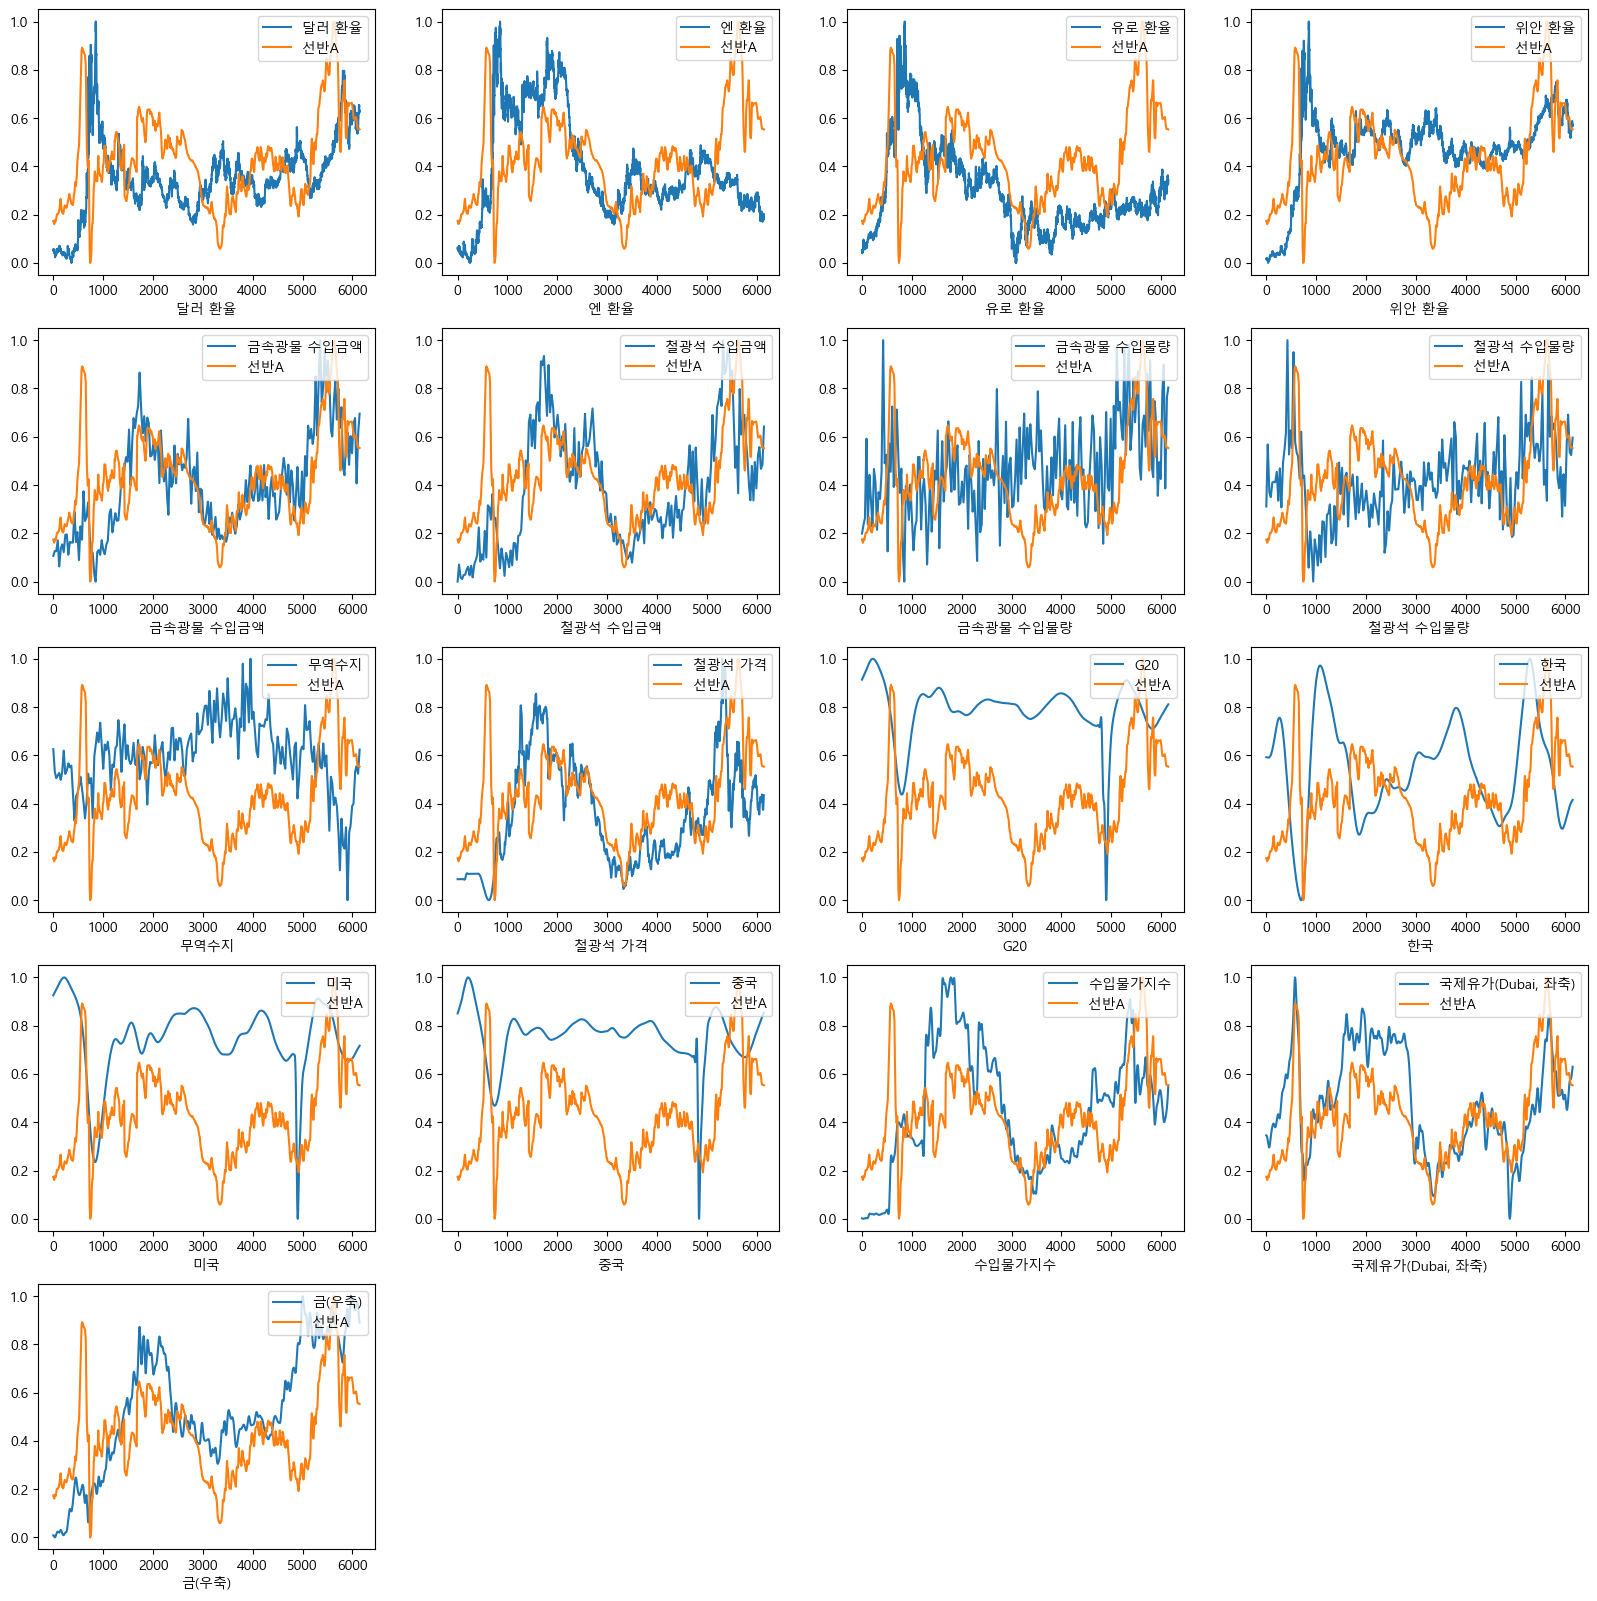

In [101]:
import matplotlib.pyplot as plt
cnt=0
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='Malgun Gothic')
plt.figure(figsize=(20,20))
for i in all_df.columns[2:len(all_df.columns)]:
    cnt+=1
    plt.subplot(5,4,cnt)
    plt.rc('font', family='Malgun Gothic')
    plt.plot(all_df[i],label=i) 
    scaler = MinMaxScaler()
    plt.plot(scaler.fit_transform(all_df[['선반A (Turning Scrap A) 평균']]),label='선반A') 
    plt.legend(loc=1)
    plt.xlabel(i)

In [79]:
# 상관계수
df_corr=all_df.iloc[:,1:].corr()['선반A (Turning Scrap A) 평균'].iloc[1:].to_frame()
df_corr

,선반A (Turning Scrap A) 평균
달러 환율,0.168338
엔 환율,0.121042
유로 환율,0.206238
위안 환율,0.271835
금속광물 수입금액,0.654380
철광석 수입금액,0.569439
금속광물 수입물량,0.231210
철광석 수입물량,0.202000
무역수지,-0.487305
철광석 가격,0.474755


In [132]:
# corr 0.45 이상인 컬럼 추출
best_index=df_corr[(abs(df_corr['선반A (Turning Scrap A) 평균'])>0.45)&(df_corr['선반A (Turning Scrap A) 평균']!=1)].index
print(best_index)

Index(['금속광물 수입금액', '철광석 수입금액', '무역수지', '철광석 가격', '수입물가지수', '국제유가(Dubai, 좌축)',
       '금(우축)'],
      dtype='object')


---
#### 3. 독립변수, 종속변수 분리
---

In [118]:
feature=all_df[best_index]
target=all_df.iloc[:]['선반A (Turning Scrap A) 평균']

---
#### 4. 모델링
---

In [135]:
# 스케일링 적용, 상관계수가 0.45 이상인 항목들 적용
import pandas as pd
from itertools import combinations
print('-'*100)
# 조합을 이용하여 모든 경우의 수 계산
for cnt in range(3,6):
    for i in combinations(best_index,cnt):
        feature=all_df[list(i)]
        target=all_df.iloc[:]['선반A (Turning Scrap A) 평균']
        # train, test 분리
        train_x=feature.iloc[:round(len(feature)*0.8),:]
        test_x=feature.iloc[round(len(feature)*0.8):,:]
        train_y=target.iloc[:round(len(feature)*0.8)]
        test_y=target.iloc[round(len(feature)*0.8):]
        # print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)
        # RandomForest
        from sklearn.ensemble import RandomForestRegressor
        model=RandomForestRegressor()
        model.fit(train_x,train_y)
        train_score_rf=model.score(train_x,train_y)
        test_score_rf = model.score(test_x,test_y)
        if test_score_rf > 0:
            print(f'RandomForest => train score : {train_score_rf:.4f}, test score : {test_score_rf:.4f}')
        # XGBoost
        from xgboost import XGBRegressor
        model=XGBRegressor()
        model.fit(train_x,train_y)
        train_score_xgb = model.score(train_x,train_y)
        test_score_xgb = model.score(test_x,test_y)
        if test_score_xgb > 0:
            print(f'XGBoost => train score : {train_score_xgb:.4f}, test score : {test_score_xgb:.4f}')
        if (test_score_rf > 0) | (test_score_xgb > 0):
            print(f'독립변수 : {list(i)}')
            print('-'*100)

----------------------------------------------------------------------------------------------------
RandomForest => train score : 0.9925, test score : 0.3621
XGBoost => train score : 0.9885, test score : 0.3589
독립변수 : ['금속광물 수입금액', '철광석 수입금액', '무역수지']
----------------------------------------------------------------------------------------------------
RandomForest => train score : 0.9971, test score : 0.1458
XGBoost => train score : 0.9936, test score : 0.1693
독립변수 : ['금속광물 수입금액', '철광석 수입금액', '철광석 가격']
----------------------------------------------------------------------------------------------------
RandomForest => train score : 0.9972, test score : 0.0282
XGBoost => train score : 0.9960, test score : 0.0941
독립변수 : ['금속광물 수입금액', '무역수지', '철광석 가격']
----------------------------------------------------------------------------------------------------
RandomForest => train score : 0.9953, test score : 0.0867
XGBoost => train score : 0.9965, test score : 0.3616
독립변수 : ['금속광물 수입금액', '무역수지', 

In [121]:
best_feature=['위안 환율', '금속광물 수입금액', '철광석 수입금액', '철광석 수입물량', '무역수지', '금(우축)']


In [122]:
import pandas as pd
all_df = pd.read_csv('./data/tsa_all.csv')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
for i in all_df.columns:
    if i!='날짜':
        all_df[i]=scaler.fit_transform(all_df[[i]])
print('-'*100)
# 독립변수, 종속변수 분리
feature = all_df[best_feature]
target = all_df['선반A (Turning Scrap A) 평균']
# train, test 분리
train_x=feature.iloc[:round(len(feature)*0.8),:]
test_x=feature.iloc[round(len(feature)*0.8):,:]
train_y=target.iloc[:round(len(feature)*0.8)]
test_y=target.iloc[round(len(feature)*0.8):]
# print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)
# RandomForest
from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor()
model.fit(train_x,train_y)
train_score_rf=model.score(train_x,train_y)
test_score_rf = model.score(test_x,test_y)
print(f'RandomForest => train score : {train_score_rf:.4f}, test score : {test_score_rf:.4f}')
# XGBoost
from xgboost import XGBRegressor
model=XGBRegressor()
model.fit(train_x,train_y)
train_score_xgb = model.score(train_x,train_y)
test_score_xgb = model.score(test_x,test_y)
print(f'XGBoost => train score : {train_score_xgb:.4f}, test score : {test_score_xgb:.4f}')
print('-'*100)

----------------------------------------------------------------------------------------------------
RandomForest => train score : 0.9992, test score : -0.1697
XGBoost => train score : 0.9993, test score : -0.1301
----------------------------------------------------------------------------------------------------


In [132]:
print('-'*100)
for cnt in range(1,len(best_feature)):
    # 조합을 이용하여 모든 경우의 수 계산
    for i in combinations(all_df[best_feature].columns,cnt):
        # 독립변수, 종속변수 분리
        feature = all_df[list(i)]
        target = all_df['선반A (Turning Scrap A) 평균']
        # train, test 분리
        train_x=feature.iloc[:round(len(feature)*0.8),:]
        test_x=feature.iloc[round(len(feature)*0.8):,:]
        train_y=target.iloc[:round(len(feature)*0.8)]
        test_y=target.iloc[round(len(feature)*0.8):]
        # print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)
        # RandomForest
        from sklearn.ensemble import RandomForestRegressor
        model=RandomForestRegressor()
        model.fit(train_x,train_y)
        train_score_rf=model.score(train_x,train_y)
        test_score_rf = model.score(test_x,test_y)
        if test_score_rf > 0:
            print(f'RandomForest => train score : {train_score_rf:.4f}, test score : {test_score_rf:.4f}')
        # XGBoost
        from xgboost import XGBRegressor
        model=XGBRegressor()
        model.fit(train_x,train_y)
        train_score_xgb = model.score(train_x,train_y)
        test_score_xgb = model.score(test_x,test_y)
        if test_score_xgb > 0:
            print(f'XGBoost => train score : {train_score_xgb:.4f}, test score : {test_score_xgb:.4f}')
        if (test_score_rf > 0) or (test_score_xgb > 0):
            print(f'독립변수 : {list(i)}')
            print('-'*100)


----------------------------------------------------------------------------------------------------
독립변수 : ['위안 환율']
----------------------------------------------------------------------------------------------------
RandomForest => train score : 0.8523, test score : 0.1379
XGBoost => train score : 0.3392, test score : 0.2164
독립변수 : ['금속광물 수입금액']
----------------------------------------------------------------------------------------------------
독립변수 : ['철광석 수입금액']
----------------------------------------------------------------------------------------------------
독립변수 : ['철광석 수입물량']
----------------------------------------------------------------------------------------------------
독립변수 : ['무역수지']
----------------------------------------------------------------------------------------------------
RandomForest => train score : 0.8582, test score : 0.0199
XGBoost => train score : 0.3878, test score : 0.0508
독립변수 : ['금(우축)']
-------------------------------------------------------------

---
#### 항목별
---

In [103]:
shift_score = {}
for item in all_df.columns[2:]:
    shift_score[item]=[]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
for i in all_df.columns:
    if i!='날짜':
        all_df[i]=scaler.fit_transform(all_df[[i]])
for item in all_df.columns[2:]:
    result = []
    for i in range(0,71,7):
        feature = all_df[[item]].shift(i).dropna()
        target = all_df['선반A (Turning Scrap A) 평균'].iloc[i:]
        #-----------------------------------------------------------------------------------------------
        # train, test 분리
        train_x=feature.iloc[:round(len(feature)*0.8),:]
        test_x=feature.iloc[round(len(feature)*0.8):,:]
        train_y=target.iloc[:round(len(feature)*0.8)]
        test_y=target.iloc[round(len(feature)*0.8):]
        # print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)
        #-----------------------------------------------------------------------------------------------
        # RandomForest
        from sklearn.ensemble import RandomForestRegressor
        model=RandomForestRegressor()
        model.fit(train_x,train_y)
        train_score_rf=model.score(train_x,train_y)
        test_score_rf = model.score(test_x,test_y)
        print(f'RandomForest => train score : {train_score_rf:.4f}, test score : {test_score_rf:.4f}')
        #-----------------------------------------------------------------------------------------------
        # XGBoost
        from xgboost import XGBRegressor
        model=XGBRegressor()
        model.fit(train_x,train_y)
        train_score_xgb = model.score(train_x,train_y)
        test_score_xgb = model.score(test_x,test_y)
        print(f'XGBoost => train score : {train_score_xgb:.4f}, test score : {test_score_xgb:.4f}')
        print(f'독립변수({i}일 shift) : {item}')
        result.append(test_score_xgb)
        print('-'*100)
        #-----------------------------------------------------------------------------------------------
    shift_score[item].append(result)


RandomForest => train score : 0.7141, test score : -2.1753
XGBoost => train score : 0.4007, test score : -2.0450
독립변수(0일 shift) : 달러 환율
----------------------------------------------------------------------------------------------------
RandomForest => train score : 0.7126, test score : -2.2366
XGBoost => train score : 0.3967, test score : -2.0150
독립변수(7일 shift) : 달러 환율
----------------------------------------------------------------------------------------------------
RandomForest => train score : 0.7098, test score : -2.2308
XGBoost => train score : 0.4004, test score : -1.9817
독립변수(14일 shift) : 달러 환율
----------------------------------------------------------------------------------------------------
RandomForest => train score : 0.7087, test score : -2.1780
XGBoost => train score : 0.4034, test score : -1.9280
독립변수(21일 shift) : 달러 환율
----------------------------------------------------------------------------------------------------
RandomForest => train score : 0.7055, test score :

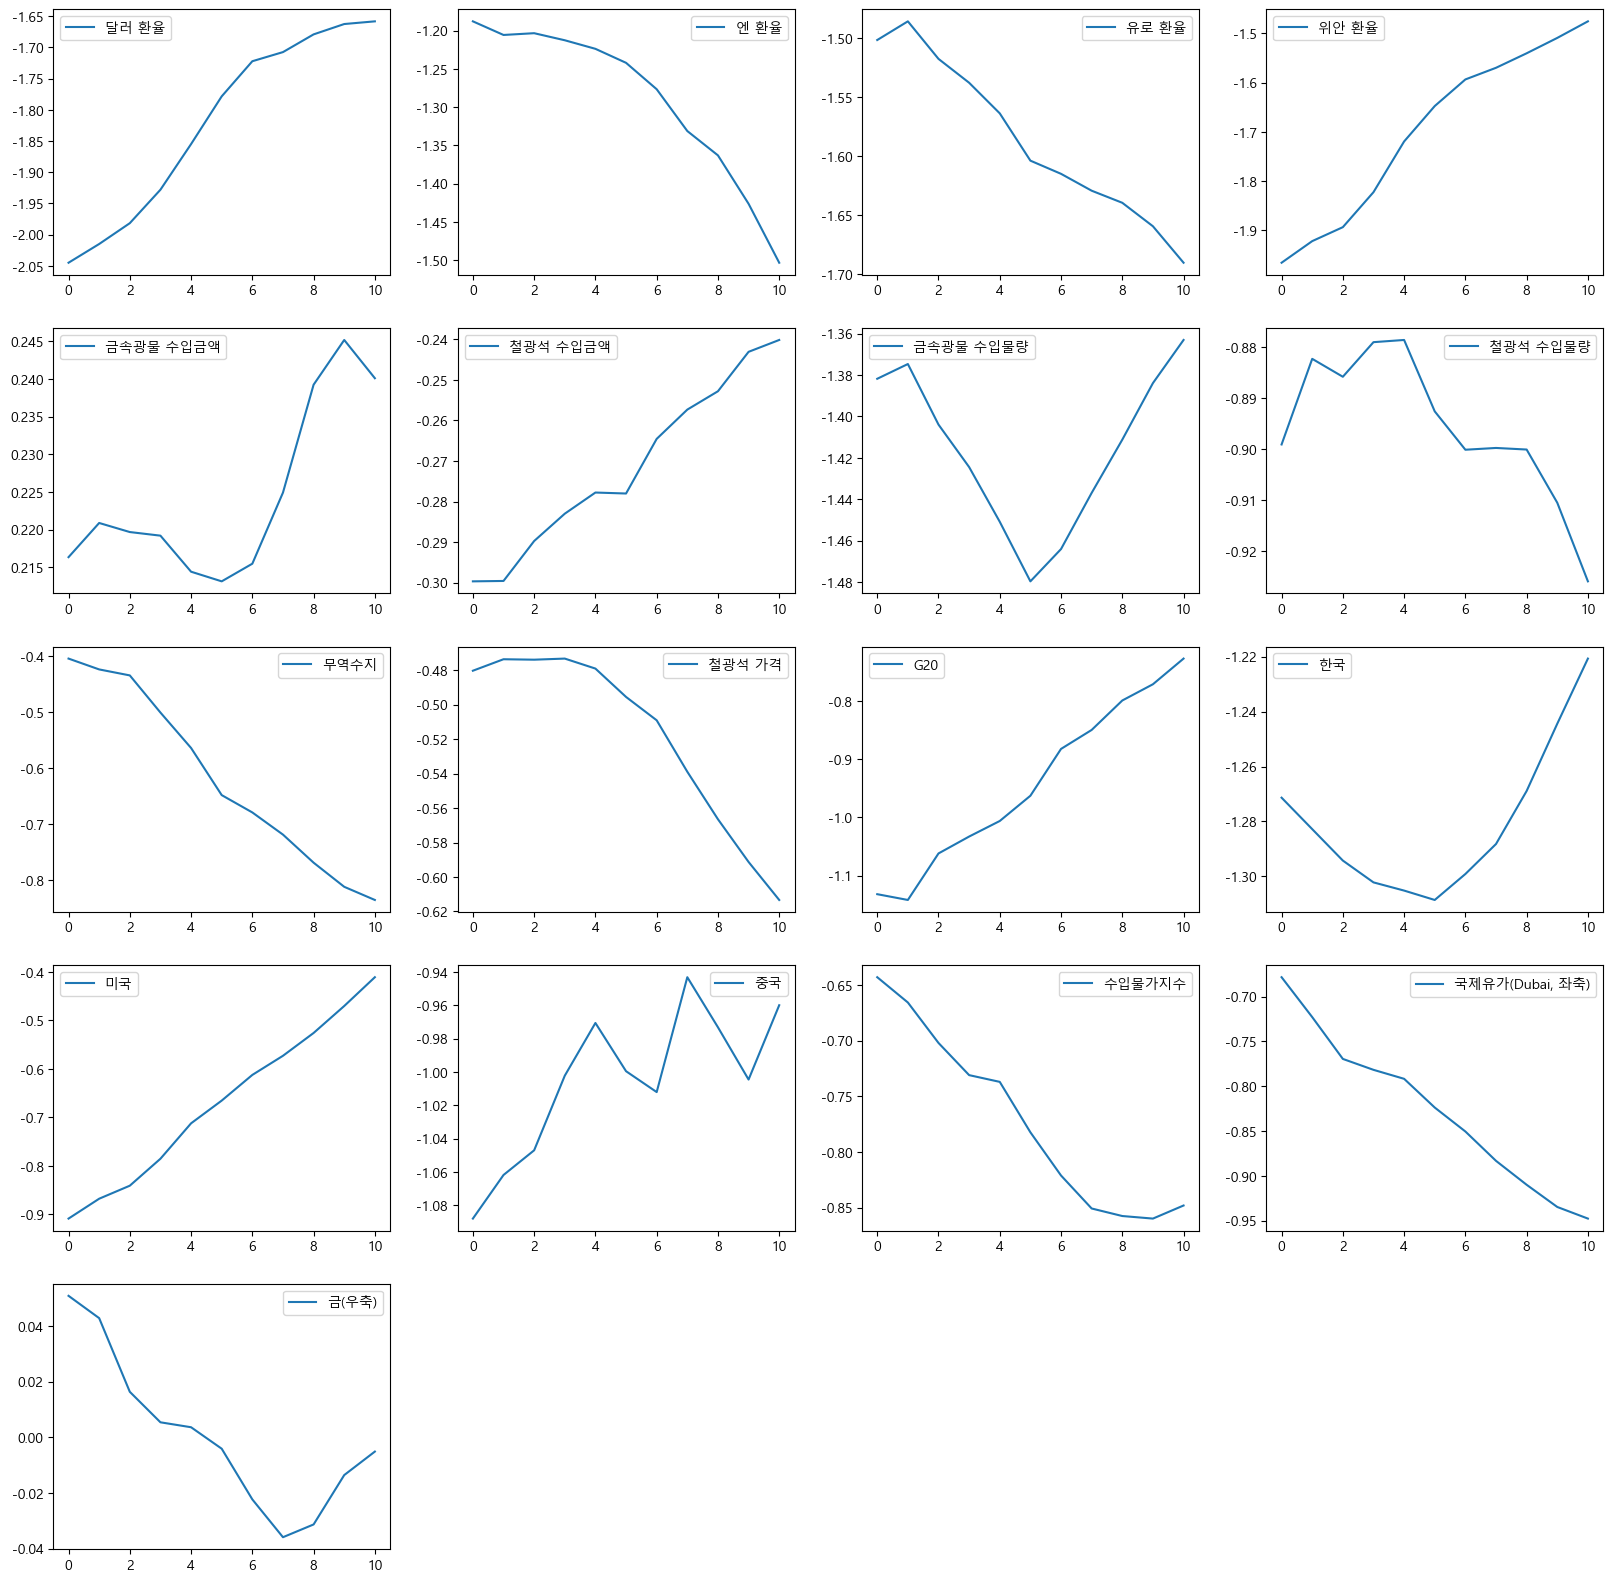

In [104]:
import matplotlib.pyplot as plt


cnt=0
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='Malgun Gothic')
plt.figure(figsize=(20,20))
for item in shift_score.keys():
    cnt+=1
    plt.subplot(5,4,cnt)
    plt.plot(shift_score[item][0],label=item)
    plt.legend()
    # print(shift_score[item])
    

---
#### shift 시 개선되는 독립변수 이용하여 학습
---

In [107]:
best_feature = ['달러 환율', '위안 환율', '금속광물 수입금액', '철광석 수입금액','미국']
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
print('-'*100)
for cnt in range(2,len(best_feature)+1):
    # 조합을 이용하여 모든 경우의 수 계산
    for i in combinations(all_df[best_feature].columns,cnt):
        # 독립변수, 종속변수 분리
        feature = all_df[list(i)].shift(64).dropna()
        target = all_df['선반A (Turning Scrap A) 평균'].iloc[64:]
        # train, test 분리
        train_x=feature.iloc[:round(len(feature)*0.8),:]
        test_x=feature.iloc[round(len(feature)*0.8):,:]
        train_y=target.iloc[:round(len(feature)*0.8)]
        test_y=target.iloc[round(len(feature)*0.8):]
        # print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)
        # RandomForest
        from sklearn.ensemble import RandomForestRegressor
        model=RandomForestRegressor()
        model.fit(train_x,train_y)
        train_score_rf=model.score(train_x,train_y)
        test_score_rf = model.score(test_x,test_y)
        if test_score_rf > 0:
            print(f'RandomForest => train score : {train_score_rf:.4f}, test score : {test_score_rf:.4f}')
        # XGBoost
        from xgboost import XGBRegressor
        model=XGBRegressor()
        model.fit(train_x,train_y)
        train_score_xgb = model.score(train_x,train_y)
        test_score_xgb = model.score(test_x,test_y)
        if test_score_xgb > 0:
            print(f'XGBoost => train score : {train_score_xgb:.4f}, test score : {test_score_xgb:.4f}')
        if (test_score_rf > 0) or (test_score_xgb > 0):
            print(f'독립변수 : {list(i)}')
            print('-'*100)


----------------------------------------------------------------------------------------------------
RandomForest => train score : 0.9656, test score : 0.2241
독립변수 : ['달러 환율', '금속광물 수입금액']
----------------------------------------------------------------------------------------------------
RandomForest => train score : 0.9744, test score : 0.3305
XGBoost => train score : 0.9426, test score : 0.3169
독립변수 : ['위안 환율', '금속광물 수입금액']
----------------------------------------------------------------------------------------------------
RandomForest => train score : 0.9793, test score : 0.0073
독립변수 : ['위안 환율', '철광석 수입금액']
----------------------------------------------------------------------------------------------------
RandomForest => train score : 0.9904, test score : 0.3020
XGBoost => train score : 0.9866, test score : 0.2074
독립변수 : ['달러 환율', '위안 환율', '금속광물 수입금액']
----------------------------------------------------------------------------------------------------
RandomForest => train score :

In [ ]:
# shift 적용 => R2스코어 하락
# 머신러닝이 아닌 시계열 및 딥러닝 모델로 접근 필요
# 문제점 : 데이터 수의 부족으로 인해 딥러닝으로 모델링이 가능할지 의문